In [2]:
!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git &>/dev/null;
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !git clone https://github.com/edgi-govdata-archiving/EEW-EJScreen.git
    %mv /content/EEW-EJScreen/ejscreen.db /content
else:
    print('Not running on CoLab')

Not running on CoLab


In [26]:
# Enter the state and CD. Then you can run all.
state = 'MA'
cd = '3'

Use shapefiles to construct an initial outline map of the district.

In [27]:
import geopandas
import folium

url = "https://theunitedstates.io/districts/cds/2012/{}-{}/shape.geojson".format( state, str(cd))       
cd_boundary = geopandas.read_file(url)
bounds = cd_boundary.bounds
map=folium.Map(location=((bounds.miny+bounds.maxy)/2., (bounds.minx+bounds.maxx)/2.), zoom_level=4)
# map.fit_bounds(bounds)
w = folium.GeoJson( cd_boundary, name = "Congressional Districts").add_to(map)


Look up the state's two-digit FIPS code from a local CSV file.

In [44]:
import pandas as pd
df = pd.read_csv("state-fips-codes.csv")
df = df[df['State_Code'] == state]
state_fips = str(df['FIPS_Code'].iloc[0]).zfill(2)
state_fips


'25'

Use the FIPS_Code for the state to identify the EJ Screen records just for this state.

In [45]:
from ECHO_modules.get_data import get_echo_data

select_columns = '"ID", "P_LDPNT_D2", "P_DSLPM_D2", "P_CANCR_D2", '
select_columns += '"P_RESP_D2", "P_PTRAF_D2", "P_PWDIS_D2", '
select_columns += '"P_PNPL_D2", "P_PRMP_D2", "P_PTSDF_D2", '
select_columns += '"P_OZONE_D2", "P_PM25_D2"'

sql = 'select {} from "EJSCREEN_2021_USPR" where DIV("ID", 10000000000) = {}' 
sql = sql.format(select_columns, state_fips)
ej_state_df = get_echo_data(sql)
# Rename the ID field to match the field in the census data block group.
ej_state_df.rename(columns={'ID':'GEOID'}, inplace=True)
ej_state_df['GEOID'] = ej_state_df['GEOID'].astype(int)
ej_state_df

,GEOID,P_LDPNT_D2,P_DSLPM_D2,P_CANCR_D2,P_RESP_D2,P_PTRAF_D2,P_PWDIS_D2,P_PNPL_D2,P_PRMP_D2,P_PTSDF_D2,P_OZONE_D2,P_PM25_D2
0,250259815011,62.923120,58.165826,58.165826,58.165826,57.233162,60.290888,58.169194,58.169194,58.169194,58.958826,58.958826
1,250079900000,62.923120,NaN,NaN,NaN,NaN,NaN,58.169194,58.169194,58.169194,NaN,NaN
2,250039333002,11.420413,50.004708,42.714753,46.000737,NaN,NaN,37.386525,54.198904,52.727678,39.431636,45.051533
3,250072004005,42.897134,56.392325,57.015122,56.315724,NaN,NaN,54.900619,57.527194,57.178168,55.938554,56.815635
4,250010134004,28.559971,41.132575,36.286874,40.664983,40.424119,NaN,24.243315,37.807124,42.127048,31.682101,38.231449
...,...,...,...,...,...,...,...,...,...,...,...,...
4980,250056517001,91.551854,86.104258,81.056309,77.457135,97.270581,NaN,99.561755,96.889632,88.711650,87.797912,82.551674
4981,250010102083,31.544627,54.044953,53.329074,54.409689,33.168459,NaN,54.226372,57.363229,56.039917,52.746351,54.791234
4982,250010103041,19.532648,39.182026,46.167657,37.174889,13.798683,NaN,40.810371,53.763705,23.245138,27.681967,36.203324
4983,250010103042,24.489700,45.314922,50.974677,45.301253,12.233419,NaN,46.102378,55.411203,41.762646,38.908680,45.078054


ej_state_df now contains the EJScreen data for all census block groups in the state.
We want to identify just those in our CD.
For that we need the bounding polygon of the CD (we have that in cd_boundary), and an interior 
point of the census block, for each census block identified by ID in ej_state_df.
The interior point of the census block is (INTPTLAT, INTPTLON) within the census_block_groups table
in a SQLite database we've created. (See the census-shapefiles.ipynb notebook in the census-shapefiles
directory.)

In [46]:
conn = sqlite3.connect("census-shapefiles/census2010.db")

bg_point_list = []
for index, row in ej_state_df.iterrows():
    # Use row['GEOID'] to look for the block group in the census db.
    sql = 'select GEOID, INTPTLAT, INTPTLON from census_block_groups where GEOID=\'{}\''.format(row['GEOID'])
    c = conn.cursor()
    c.execute(sql)
    block_group = c.fetchone()
    bg_point_list.append(block_group)
conn.close()    

Identify the EJ Screen records within this CD.

In [47]:
import geopandas as gpd

bg_points_df = pd.DataFrame(bg_point_list, columns =['GEOID', 'INTPTLAT', 'INTPTLON'])
bg_points_gdf = gpd.GeoDataFrame(bg_points_df, crs='epsg:4269',
                    geometry=gpd.points_from_xy(bg_points_df.INTPTLON, bg_points_df.INTPTLAT))
bg_points_gdf = bg_points_gdf.to_crs(4326)
within_points = gpd.sjoin(bg_points_gdf, cd_boundary, op='within')
within_points

,GEOID,INTPTLAT,INTPTLON,geometry,index_right
711,250092501001,42.705401,-71.158197,POINT (-71.15820 42.70540),0
712,250092502001,42.709211,-71.186832,POINT (-71.18683 42.70921),0
713,250092502002,42.703787,-71.179265,POINT (-71.17927 42.70379),0
714,250092502003,42.702685,-71.184777,POINT (-71.18478 42.70269),0
715,250092502004,42.701784,-71.188230,POINT (-71.18823 42.70178),0
...,...,...,...,...,...
4618,250277614002,42.468243,-71.573980,POINT (-71.57398 42.46824),0
4619,250277614003,42.506053,-71.555693,POINT (-71.55569 42.50605),0
4620,250277614004,42.510617,-71.591759,POINT (-71.59176 42.51062),0
4621,250277614005,42.539412,-71.569116,POINT (-71.56912 42.53941),0


Plot the census block groups as a sanity check.

In [48]:
for i in range(0,len(within_points)):
   folium.Marker(
      location=[within_points.iloc[i]['INTPTLAT'], within_points.iloc[i]['INTPTLON']],
      popup=within_points.iloc[i]['GEOID'],
   ).add_to(map)
map

We have the census block groups in the within_points dataframe, and the EJ screen records for
all census blocks in the state in ej_state_df. Filter ej_state_df where its ID field matches
GEOID in within_points.

In [49]:
ej_columns = ['GEOID', 'P_LDPNT_D2', 'P_DSLPM_D2', 'P_CANCR_D2', 'P_RESP_D2', 'P_PTRAF_D2', 'P_PWDIS_D2',
     'P_PNPL_D2', 'P_PRMP_D2', 'P_PTSDF_D2', 'P_OZONE_D2', 'P_PM25_D2']

ej_cd_df = within_points.merge(ej_state_df[ej_columns], on='GEOID')
ej_cd_df

,GEOID,INTPTLAT,INTPTLON,geometry,index_right,P_LDPNT_D2,P_DSLPM_D2,P_CANCR_D2,P_RESP_D2,P_PTRAF_D2,P_PWDIS_D2,P_PNPL_D2,P_PRMP_D2,P_PTSDF_D2,P_OZONE_D2,P_PM25_D2
0,250092501001,42.705401,-71.158197,POINT (-71.15820 42.70540),0,99.245043,90.132963,90.121541,92.393795,98.343949,87.835853,91.959858,95.272274,99.432730,94.810961,90.615959
1,250092502001,42.709211,-71.186832,POINT (-71.18683 42.70921),0,98.079820,82.769544,87.511759,83.521864,95.323786,83.074080,85.659436,92.008096,96.613662,86.504013,81.697212
2,250092502002,42.703787,-71.179265,POINT (-71.17927 42.70379),0,99.427974,86.028136,91.452547,87.793774,96.239726,84.448867,88.323139,94.719042,97.991898,90.733398,85.886957
3,250092502003,42.702685,-71.184777,POINT (-71.18478 42.70269),0,95.405556,78.345294,81.651874,77.977730,93.054874,83.212886,82.481125,90.263072,93.929036,80.563342,76.353098
4,250092502004,42.701784,-71.188230,POINT (-71.18823 42.70178),0,65.912070,58.888422,58.742138,58.619901,64.596430,71.779572,59.572715,61.477088,65.900266,59.437292,59.332790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,250277614002,42.468243,-71.573980,POINT (-71.57398 42.46824),0,28.360647,27.124628,30.318482,25.348472,8.444174,NaN,12.305557,43.874584,39.902139,26.253263,31.854354
488,250277614003,42.506053,-71.555693,POINT (-71.55569 42.50605),0,11.417409,29.099988,32.797308,27.796448,39.935052,NaN,7.568539,44.262921,37.673377,28.997549,34.420476
489,250277614004,42.510617,-71.591759,POINT (-71.59176 42.51062),0,9.205400,30.084604,34.037043,29.064832,17.697781,30.590380,4.658990,41.939348,22.078771,30.340257,35.640307
490,250277614005,42.539412,-71.569116,POINT (-71.56912 42.53941),0,14.061403,28.924686,32.599159,27.602396,12.506848,31.785281,1.792925,43.005181,24.327567,28.766166,34.219854


Select only the 11 columns in EJ Screen for national percentiles of the census block group among all groups in the U.S.

In [50]:
columns = ['P_LDPNT_D2', 'P_DSLPM_D2', 'P_CANCR_D2', 'P_RESP_D2', 'P_PTRAF_D2', 'P_PWDIS_D2', 
           'P_PNPL_D2', 'P_PRMP_D2', 'P_PTSDF_D2', 'P_OZONE_D2', 'P_PM25_D2']
ej_cd_df[columns] = ej_cd_df[columns].apply(pd.to_numeric)
ej_cd_scores = ej_cd_df[columns]
means = pd.DataFrame(ej_cd_scores.mean())
new_columns=['Lead paint', 'Diesel', 'Air toxics cancer', 'Air toxics resp',
             'Traffic', 'Water discharge', 'NPL sites', 'RMP facilities',
             'TSDF facilities', 'Ozone', 'PM2.5']
means = means.set_axis(new_columns, axis=0)

stdev = pd.DataFrame(ej_cd_scores.std())
stdev = stdev.set_axis(new_columns, axis=0)


Write out the filtered data.

In [51]:
ej_cd_scores.to_csv('ejscreen-{}{}-percentiles.csv'.format(state, cd))

Put the scores for the census block groups into 20 5-percent bins. Then count how many block groups 
have gone into each bin.
Assign each bin the mid-point of its range--2.5, 7.5, ... 92.5, 97.5

In [52]:
df2 = pd.melt(ej_cd_scores)
df2['value2'] = pd.to_numeric(df2['value'], errors='ignore')
df2['bins'] = pd.cut(df2['value2'], bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

In [53]:
newdf = pd.DataFrame(columns=['metric', 'value', 'count'])
for metric in columns:
    tempdf = df2[df2['variable'] == metric]
    for bin in tempdf['bins'].unique():
        try:
            midpoint = (bin.left + bin.right)/2
            tempdf2 = tempdf[tempdf['bins'] == bin]
            count = 2 * tempdf2['value'].count()
            new_row = {'metric':metric, 'value':midpoint, 'count':float(count)}
            # breakpoint()
            newdf = newdf.append(new_row,ignore_index=True)
        except AttributeError:
            continue
newdf       
    

,metric,value,count
0,P_LDPNT_D2,97.5,66.0
1,P_LDPNT_D2,67.5,20.0
2,P_LDPNT_D2,92.5,82.0
3,P_LDPNT_D2,87.5,76.0
4,P_LDPNT_D2,82.5,38.0
...,...,...,...
207,P_PM25_D2,32.5,94.0
208,P_PM25_D2,12.5,50.0
209,P_PM25_D2,17.5,66.0
210,P_PM25_D2,7.5,20.0


Plot the count of census blocks in the 20 5-percent bins by assigning a dot whose size
is proportional to the count. Also plot a line showing one standard deviation of the
data around the mean. 

This standard deviation is a measure of the inequality within the district--if
all census block groups were equal the standard deviation would be zero; if there are 
many very high (i.e. bad) EJ scores and also many other low EJ scores, the standard
deviation will be large.

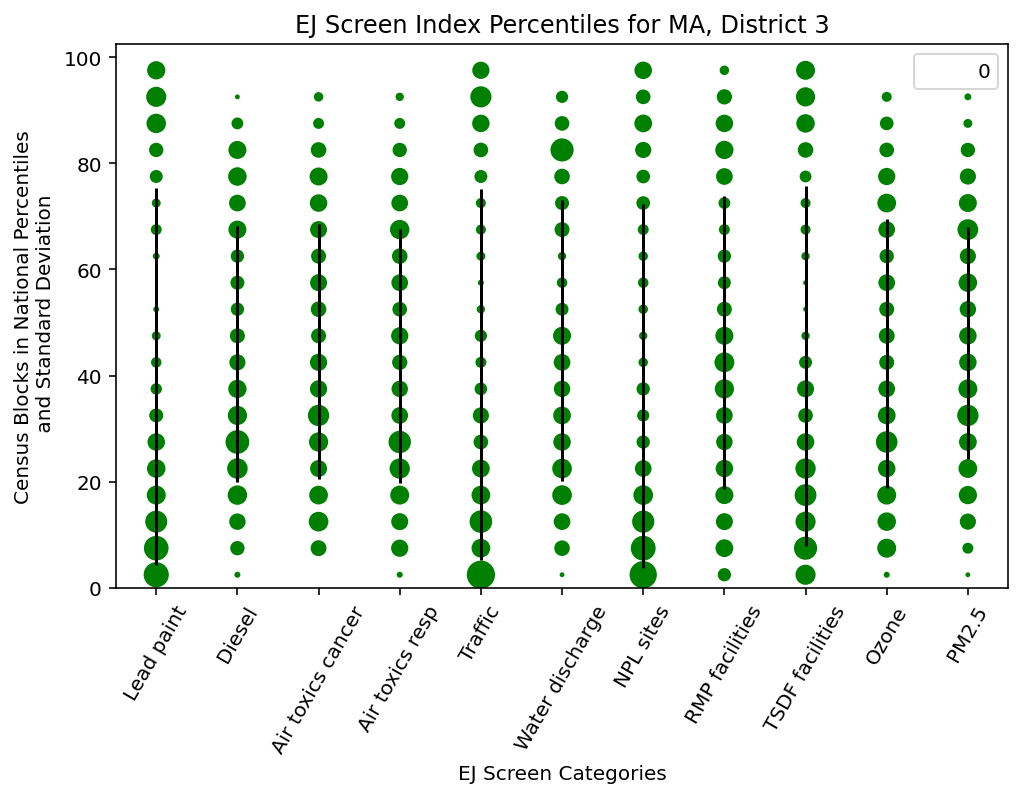

In [54]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8, 5]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

means.plot(kind='bar', alpha=0., yerr = stdev)
# means_plus_stdev.plot(kind='bar', alpha=0.3)
plt.scatter(x=newdf['metric'], y=newdf['value'], sizes=newdf['count'],
           color='Green')

plt.title("EJ Screen Index Percentiles for {}, District {}".format(state,cd))
plt.xlabel("EJ Screen Categories")
plt.ylabel("Census Blocks in National Percentiles\n and Standard Deviation")
ax = plt.gca()
ax.set_xticklabels(labels=new_columns,rotation=60)
# plt.ylim(0,100)
# plt.axhline(y = 50, color = 'r', linestyle = '-')
filename = "graph-{}-{}.png".format(state, cd)
plt.savefig(filename, bbox_inches="tight")

To do: 
    Compute these std dev figures for all CDs, into ej_screen_cd_stdev_rankings.csv. That is produced by the all_regions.ipynb notebook.
    

In [ ]:
xdf = pd.read_csv('ej_screen_cd_stdev_rankings.csv')
ydf = xdf[['Lead_Paint.Pct','Diesel.Pct','Air_toxics_cancer.Pct','Air_toxics_resp.Pct',
                   'Traffic.Pct','Water_discharge.Pct','NPL_sites.Pct','RMP_facilities.Pct',
                  'TSDF_facilities.Pct','Ozone.Pct','PM2.5.Pct','State','CD']]
zdf = ydf.loc[ydf['State'] == state]
rank_df = zdf.loc[zdf['CD'] == int(cd)]

In [ ]:
import numpy as np

grades = ['A','B','C','D','F']

columns = list(rank_df)
for i in columns:
    nm = rank_df[i].name
    if nm != 'State' and nm != 'CD':
        s = rank_df[i]
        value = s[s.index[0]]
        grade = 'None'
        if np.issubdtype(rank_df[i].dtype, np.number):
            value = int(value/0.2)
            grade = grades[value]
        print('{} - Grade for "fairness" in the district is {} ({} percentile nationally)'.format(
            nm, grade, int(s[s.index[0]]*100)))


In [1]:
print("{: >30}".format("Hansen"))

                        Hansen
